# 🛠️ Setup

In [1]:
import os
!pip install ray
import ray
!pip install python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 61.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.8/534.8 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 44.4 MB/s eta 0:00:00


2024-01-09 06:46:11,798	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [3]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-01-09 06:46:30,221	WARNING utils.py:575 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2024-01-09 06:46:30,222	WARNING utils.py:587 -- Ray currently does not support initializing Ray with fractional cpus. Your num_cpus will be truncated from 14.4 to 14.
2024-01-09 06:46:30,225	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 4000002048 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray c

Python version:,3.8.17
Ray version:,2.9.0


In [4]:
ray.cluster_resources()

{'node:__internal_head__': 1.0,
 'object_store_memory': 10000000000.0,
 'memory': 43270212608.0,
 'CPU': 14.0,
 'node:10.1.17.11': 1.0}

In [6]:
# Workers (1 g4dn.xlarge)
num_workers = 5
resources_per_worker={"CPU": 14, "GPU": 0}

If you are running this on a local laptop (no GPU), use the CPU count from `ray.cluster_resources()` to set your resources. For example if your machine has 10 CPUs:

```python
num_workers = 6  # prefer to do a few less than total available CPU (1 for head node + 1 for background tasks)
resources_per_worker={"CPU": 1, "GPU": 0}
```

In [7]:
# Storage
EFS_DIR = os.getcwd()
print (EFS_DIR)

/home/datascience


# Data

## 🔢 Data ingestion

In [8]:
import pandas as pd

In [9]:
# Data ingestion
DATASET_LOC = "dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## ✂️ Data splitting

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [12]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [13]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [14]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## 🔍 Exploratory Data Analysis (EDA)

Exploratory data analysis to understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc.) depending on how well the problem is defined.

In [17]:
from collections import Counter
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
!pip install WordCloud
from wordcloud import WordCloud, STOPWORDS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.1/520.1 kB 41.5 MB/s eta 0:00:00


In [18]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

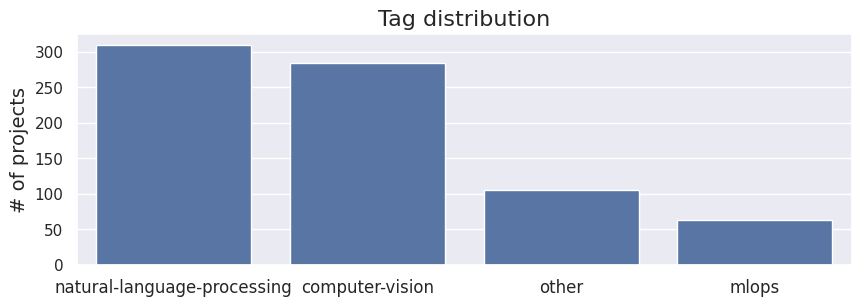

In [19]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

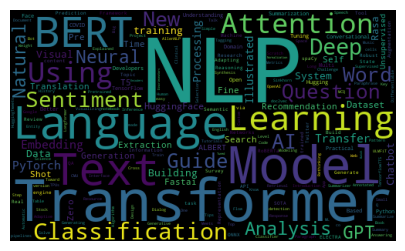

In [20]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Looks like the `title` text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the `description` text feature as well. This information will become useful when we decide how to use our features for modeling.

## ✨ Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we split the data first before preprocessing to avoid data leaks.

In [23]:
import json
!pip install nltk
!pip install re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


### Feature engineering

We can combine existing input features to create new meaningful signal (helping the model learn).

In [24]:
# Feature engineering
df["text"] = df.title + " " + df.description

### Clean text

In [25]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datascience/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [27]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Clean DataFrame

In [28]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Label encoding

We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [29]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [30]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [31]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [32]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a [tokenizer](https://huggingface.co/allenai/scibert_scivocab_uncased/blob/main/vocab.txt) that was used for a pretrained LLM ([scibert](https://huggingface.co/allenai/scibert_scivocab_uncased)) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [35]:
import numpy as np
!pip install transformers
!pip install torch
from transformers import BertTokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 109.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 112.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━

In [36]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [37]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [38]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

<hr>

We'll combine all of our preprocessing steps into function:

In [39]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [40]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

### Distributed preprocessing

The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [44]:
from mlops.data import stratify_split
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

ModuleNotFoundError: No module named 'pyarrow'

In [ ]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

In [ ]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [ ]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

In [ ]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

# Training

When developing models, it's always a best practice to start with the simplest models and slowly motivate more complex models. For example our baseline model progression would be:

1. random model (predict labels randomly)
2. rule-based model (pattern match labels in input text)
3. logistic regression (td-idf vectors from text)
4. CNN (apply character filters over text)
5. Fine-tune LLM (this notebook)

We cover all of these methods in our but since our focus here in on MLOps, we will skip directly to fine-tuning an LLM for our task.

We'll first set up some functions that will help us achieve complete reproducibility.

In [ ]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [ ]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [ ]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self

    def transform(self, ds):
        return ds.map_batches(
            preprocess,
            fn_kwargs={"class_to_index": self.class_to_index},
            batch_format="pandas")

## 🤖 Model

In [ ]:
import torch.nn as nn
from transformers import BertModel

In [ ]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

In [ ]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

In [ ]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs

    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [ ]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

## 📦 Batching

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (`padding="longest"`). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom `collate_fn` to repad the items in our training batches.

In [ ]:
from ray.train.torch import get_device

In [ ]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [ ]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

> `pad=(0, max_len)` in [F.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch-nn-functional-pad) refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the `0`) and only right-padding. And the `constant` mode refers to each element being padded to a constant size (size of longest element in the input).

In [ ]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

## 🧮 Utilities

In [ ]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel

In [ ]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [ ]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [ ]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

Our dataset doesn't suffer from horrible class imbalance, but if it did, we could easily account for it through our loss function.

```python
# Class weights
batch_counts = []
for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
counts = [sum(count) for count in zip(*batch_counts)]
class_weights = np.array([1.0/count for i, count in enumerate(counts)])
class_weights_tensor = torch.Tensor(class_weights).to(get_device())

# Training components
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
...
```

## 🗂️ Configurations

In [ ]:
from mlops.config import EFS_DIR

In [ ]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [ ]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

In [ ]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path=EFS_DIR)

## 🚂 Training

In [ ]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [ ]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor =  preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

In [2]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

NameError: name 'ray' is not defined

In [ ]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [ ]:
%%time
# Train
results = trainer.fit()

In [ ]:
# Metrics per epoch
results.metrics_dataframe

In [ ]:
# Best checkpoints
results.best_checkpoints

### Evaluation

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()

    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}

    def get_preprocessor(self):
        return self.preprocessor

    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

In [ ]:
# Artifacts
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Test (holdout) dataset
HOLDOUT_LOC = "holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

In [ ]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

In [ ]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

In [ ]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])

    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

### Inference

In [ ]:
import pandas as pd

In [ ]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [ ]:
def predict_proba(ds, predictor):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    results = []
    for i, prob in enumerate(y_prob):
        tag = preprocessor.index_to_class[prob.argmax()]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

# 🧪 Experiment tracking

So far, we've been training our models but we don't have a way to more deeply track and compare them. We'll achieve this but defining a proper process for experiment tracking which we'll use for all future experiments (including hyperparameter optimization). Experiment tracking is the processing of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to:

- **Organize** all the necessary components of a specific experiment. It's important to have everything in one place and know where it is so you can use them later.
- **Reproduce** past results (easily) using saved experiments.
- **Log** iterative improvements across time, data, ideas, teams, etc.

There are many options for experiment tracking but we're going to use [MLflow](https://mlflow.org/) (100% free and [open-source](https://github.com/mlflow/mlflow)) because it has all the functionality we'll need (and [growing integration support](https://docs.ray.io/en/latest/tune/examples/tune-mlflow.html)). There are also several popular options such as a [Comet ML](https://www.comet.ml/site/) (Used by Google AI, HuggingFace, etc.) and [Weights and Biases](https://www.wandb.com/) (Used by Open AI, Toyota Research, etc.). These are fantastic options if you want a fully managed experiment tracking solution.

In [ ]:
import mlflow
from pathlib import Path
from ray.tune.logger.mlflow import MLflowLoggerCallback
import time

In [ ]:
# Config MLflow
MODEL_REGISTRY = Path(f"{EFS_DIR}/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

In [ ]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [ ]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR
)

In [ ]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [ ]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

In [ ]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [ ]:
%%time
# Train
results = trainer.fit()

In [ ]:
results.metrics_dataframe

In [ ]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

In [ ]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

### Dashboard

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port:

```bash
mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri $EFS_DIR/mlflow
```

MLFlow creates a main dashboard with all your experiments and their respective runs. We can sort runs by clicking on the column headers.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/dashboard.png" width="1000" alt="mlflow runs">

And within each run, we can view metrics, parameters, artifacts, etc.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/params.png" width="1000" alt="mlflow params">

And we can even create custom plots to help us visualize our results.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/plots.png" width="1000" alt="mlflow plots">

### Loading

In [ ]:
from ray.train import Result
from urllib.parse import urlparse

In [ ]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path  # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

In [ ]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

# ⚙ Hyperparameter tuning

In [ ]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [ ]:
# Number of trials (small sample)
num_runs = 2

In [ ]:
# Set up
set_seeds()

In [ ]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [ ]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

In [3]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

NameError: name 'TorchTrainer' is not defined

In [ ]:
# MLflow callback
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [ ]:
# Run configuration
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR)

In [ ]:
# Hyperparameters to start with
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4, "lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)  # trade off b/w optimization and search space

In [ ]:
# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

In [ ]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5,  # min epoch (<time_attr>) per trial
)

In [ ]:
# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)

In [ ]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)

In [ ]:
%%time
# Tune
results = tuner.fit()

In [ ]:
# All trials in experiment
results.get_dataframe()

In [ ]:
# Best trial's epochs
best_trial = results.get_best_result(metric="val_loss", mode="min")
best_trial.metrics_dataframe

In [ ]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

In [ ]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

In [ ]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

# ⚖️ Evaluation

So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

- Coarse-grained metrics
- Fine-grained metrics
- Confusion matrix
- Confidence learning
- Slice metrics

In [ ]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [ ]:
# Artifacts
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# y_test
preprocessed_ds = preprocessor.transform(test_ds)
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_test = np.stack([item["targets"] for item in values])

In [ ]:
# y_prob
outputs = preprocessed_ds.map_batches(predictor.predict_proba)
y_prob = np.array([d["output"] for d in outputs.take_all()])

In [ ]:
# y_prob
print (np.shape(y_test))
print (np.shape(y_prob))

In [ ]:
# Add columns (for convenience)
test_df = test_ds.to_pandas()
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = test_df.index.map(lambda i: preprocessor.index_to_class[y_pred[i]])
test_df.head()

### Coarse-grained metrics

In [ ]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

### Fine-grained metrics

In [ ]:
from collections import OrderedDict

In [ ]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [ ]:
# Metrics for a specific class
tag = "natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

In [ ]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

### Confusion matrix

- **True positives (TP)**: learn about where our model performs well.
- **False positives (FP)**: potentially identify samples which may need to be relabeled.
- False negatives (FN): identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [ ]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [ ]:
print (tp)
print (fp)
print (fn)

In [ ]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{test_df.iloc[index].text}")
            print (f"    true: {test_df.tag[index]}")
            print (f"    pred: {test_df.prediction[index]}\n")

### Confidence learning

While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific labeling quality as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

**Categorical**
- prediction is incorrect (also indicate TN, FP, FN)
- confidence score for the correct class is below a threshold
- confidence score for an incorrect class is above a threshold
- standard deviation of confidence scores over top N samples is low
- different predictions from same model using different parameters

**Continuous**
- difference between predicted and ground-truth values is above some %



> The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

In [ ]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test==index)[0]

In [ ]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({
            "text": f"{test_df.iloc[i].text}",
            "true": test_df.tag[i],
            "pred": test_df.prediction[i],
            "prob": prob})

In [ ]:
low_confidence[0:3]

But these are fairly crude techniques because neural networks are easily [overconfident](https://arxiv.org/abs/1706.04599) and so their confidences cannot be used without calibrating them.


<div class="ai-center-all mt-1">
  <small>Modern (large) neural networks result in higher accuracies but are over confident.<br><a href="https://arxiv.org/abs/1706.04599" target="_blank">On Calibration of Modern Neural Networks</a></small>
</div>

* **Assumption**: *“the probability associated with the predicted class label should reflect its ground truth correctness likelihood.”*
* **Reality**: *“modern (large) neural networks are no longer well-calibrated”*
* **Solution**: apply temperature scaling (extension of [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling){:target="_blank"}) on model outputs

Recent work on [confident learning](https://arxiv.org/abs/1911.00068) focuses on identifying noisy labels while accounting for this overconfidence which can then be properly relabeled and used for training.

In [ ]:
import cleanlab
from cleanlab.filter import find_label_issues

In [ ]:
# Find label issues
label_issues = find_label_issues(labels=y_test, pred_probs=y_prob, return_indices_ranked_by="self_confidence")
test_df.iloc[label_issues].drop(columns=["text"]).head()

Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predictions alongside the data. This way, we can know if we need to relabel, upsample, etc. to improve our performance. Analysis like this could also shed light on the task itself. For example, you may notice that some projects involve multiple data modalities and so it's difficult to just assing one tag. So perhaps it might be better to make this taks a multilabel classification task instead (it does but we simplified it for this course).

### Slice metrics

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

- Target / predicted classes (+ combinations)
- Features (explicit and implicit)
- Metadata (timestamps, sources, etc.)
- Priority slices / experience (minority groups, large customers, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [ ]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [ ]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs."""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return (nlp_project and llm_project)

In [ ]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's [`slicing_function`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slicing_function.html) to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using [`slice_dataframe`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slice_dataframe.html).

In [ ]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

In [ ]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

We can define even more slicing functions and create a slices record array using the [`PandasSFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.PandasSFApplier.html). The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [ ]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

To calculate metrics for our slices, we could use [snorkel.analysis.Scorer](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/analysis/snorkel.analysis.Scorer.html) but we've implemented a version that will work for multiclass or multilabel scenarios.

In [ ]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [ ]:
print(json.dumps(metrics["slices"], indent=2))

Slicing can help identify sources of *bias* in our data. For example, our model has most likely learned to associated algorithms with certain applications such as CNNs used for computer vision or transformers used for NLP projects. However, these algorithms are not being applied beyond their initial use cases. We’d need ensure that our model learns to focus on the application over algorithm. This could be learned with:

- enough data (new or oversampling incorrect predictions)
- masking the algorithm (using text matching heuristics).

### Interpretability

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as [SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) or [LIME](https://github.com/marcotcr/lime) (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [ ]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

[`LimeTextExplainer.explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance) function requires a `classifier_fn` that takes in a list of strings and outputs the predicted probabilities.

In [ ]:
def classifier_fn(texts):
    ds = ray.data.from_items([{"title": text, "description": "", "tag": "other"} for text in texts])
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [ ]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
explainer.explain_instance(text, classifier_fn=classifier_fn, top_labels=1).show_in_notebook(text=True)

### Behavioral testing

In [ ]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

In [ ]:
# DIRectional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

In [ ]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

# 🚀 Serving

### Batch inference (offline)

In [ ]:
import ray.data
from ray.data import ActorPoolStrategy

In [ ]:
# Artifacts
run_id = sorted_runs.iloc[0].run_id
best_checkpoint = get_best_checkpoint(run_id=run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Batch inference
preprocessed_ds = preprocessor.transform(test_ds)
compute = ActorPoolStrategy(min_size=1, max_size=2)
outputs = preprocessed_ds.map_batches(predictor, batch_size=128, compute=compute)
np.array([d["output"] for d in outputs.take_all()])

### Online inference (real-time)

While we can achieve batch inference at scale, many models will need to be served in an real-time manner where we may need to deliver predictions for many incoming requests (high throughput) with low latency.

In [ ]:
from fastapi import FastAPI
from ray import serve
import requests
from starlette.requests import Request

In [ ]:
# Define application
app = FastAPI(
    title="Made With ML",
    description="Classify machine learning projects.",
    version="0.1")

We'll start by defining our FastAPI application which involves initializing a predictor (and preprocessor) from the best checkpoint for a particular run (specified by `run_id`). We'll also define a `predict` function that will be used to make predictions on our input data.

In [ ]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeployment:
    def __init__(self, run_id):
        """Initialize the model."""
        self.run_id = run_id
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)
        return {"results": results}

> `async def` refers to an asynchronous function (when we call the function we don't have to wait for the function to complete executing). The `await` keyword is used inside an asynchronous function to wait for the completion of the `request.json()` operation.

In [ ]:
# Run service
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
run_id = sorted_runs.iloc[0].run_id
serve.run(ModelDeployment.bind(run_id=run_id), route_prefix="/")

In [ ]:
# Query
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
json_data = json.dumps({"title": title, "description": description})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

The issue with neural networks (and especially LLMs) is that they are notoriously overconfident. For every input, they will always make some prediction. And to account for this, we have an `other` class but that class only has projects that are not in our accepted tags but are still machine learning related nonetheless. Here's what happens when we input complete noise as our input:

In [ ]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [ ]:
# Shutdown
serve.shutdown()

### Custom logic

To make our service a bit more robust, let's add some custom logic to predict the `other` class if the probability of the predicted class is below a certain `threshold` probability.

In [ ]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeploymentRobust:
    def __init__(self, run_id, threshold=0.9):
        """Initialize the model."""
        self.run_id = run_id
        self.threshold = threshold
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)

        # Apply custom logic
        for i, result in enumerate(results):
            pred = result["prediction"]
            prob = result["probabilities"]
            if prob[pred] < self.threshold:
                results[i]["prediction"] = "other"

        return {"results": results}

In [ ]:
# Run service
serve.run(ModelDeploymentRobust.bind(run_id=run_id, threshold=0.9), route_prefix="/")

In [ ]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [ ]:
# Shutdown
serve.shutdown()

---